# Managing Unbalanced Targets and Preventing Data Leakage

## Objectives

- avoid letting information about test sets get into the training of models
- use best practices for building non-leaky workflows
- repair leaky workflows
- recognize imbalanced classification targets 
- describe sampling techniques that address unbalanced targets

In [46]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error

# First: Avoiding Data Leakage

We have encountered the idea of splitting our data into two, *training* our model on one bit and then *testing* it on the other. The goal is to have an unbiased assessment of our model, and so we want to make sure that nothing about our test data sneaks into the training run of the model, so our test is more like a true test.

### What's Wrong With This Picture?

Look at the below code. We were sure to fit our model on our training data - does that mean we did everything right?

In [47]:
X, y = load_diabetes(return_X_y=True)

In [48]:
ss = StandardScaler().fit(X)
X_scld = ss.transform(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_scld, y, random_state=42)

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.coef_, lr.intercept_)

[  2.27107279 -11.5103763   25.30316447  18.14921047 -43.68812386
  24.17505729   5.56228784  12.81809837  33.09612684   1.25207795] 151.66516982689885


#### Discuss:

- scaler fit before train/test split
- so what? 
    - standard scaler fits 2 things: mean, standard deviation
    - X and X_train will have different means! different standard deviations!


In [51]:
X_train[:,0].mean()

0.021344086928671444

In [52]:
X[:,0].mean()

-3.6396225400041895e-16

In [53]:
# If you found an error/mistake, let's fix it!

X_train, X_test, y_train, y_test2 = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_sc = scaler.transform(X_train)
X_te_sc = scaler.transform(X_test)


lr2 = LinearRegression()
lr2.fit(X_tr_sc, y_train)
print(lr2.coef_, lr2.intercept_)

[  2.21493322 -11.51452473  25.07685109  18.24943843 -44.14403151
  24.5135485    5.4971345   13.00640779  33.3797142    1.24791796] 154.34441087613294


### Error Comparison

It's worth pointing out that, **for linear models**, there is **no** difference in modeling error:

In [54]:
y_test_hat = lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_hat, squared=False)
print(f"Our test RMSE for this model is {round(mse, 2)}.")

Our test RMSE for this model is 72.75.


In [55]:
y_test2_hat = lr2.predict(X_te_sc)
rmse = mean_squared_error(y_test2, y_test2_hat, squared=False)
print(f"Our test RMSE for this model is {round(mse, 2)}.")

Our test RMSE for this model is 72.75.


This will **NOT** be true for other sorts of models that use different loss functions.

## Preprocessing

In general all preprocessing steps are subject to the same dangers here. Consider the preprocessing step of one-hot-encoding:

In [56]:
gun_poll = pd.read_csv('data/guns-polls.csv')

In [57]:
gun_poll.head()

,Question,Start,End,Pollster,Population,Support,Republican Support,Democratic Support,URL
0,age-21,2/20/18,2/23/18,CNN/SSRS,Registered Voters,72,61,86,http://cdn.cnn.com/cnn/2018/images/02/25/rel3a...
1,age-21,2/27/18,2/28/18,NPR/Ipsos,Adults,82,72,92,https://www.ipsos.com/en-us/npripsos-poll-majo...
2,age-21,3/1/18,3/4/18,Rasmussen,Adults,67,59,76,http://www.rasmussenreports.com/public_content...
3,age-21,2/22/18,2/26/18,Harris Interactive,Registered Voters,84,77,92,http://thehill.com/opinion/civil-rights/375993...
4,age-21,3/3/18,3/5/18,Quinnipiac,Registered Voters,78,63,93,https://poll.qu.edu/national/release-detail?Re...


In [58]:
gun_poll['Pollster'].value_counts()

YouGov                 12
Morning Consult        11
Quinnipiac              8
NPR/Ipsos               7
CNN/SSRS                5
CBS News                4
Suffolk                 2
Rasmussen               2
Marist                  1
Harvard/Harris          1
SurveyMonkey            1
YouGov/Huffpost         1
Harris Interactive      1
ABC/Washington Post     1
Name: Pollster, dtype: int64

Now if I were to fit a one-hot encoder to the whole `Pollster` column here, the encoder would learn all the categories. But I need to prepare myself for the real-world possibility that unfamiliar categories may show up in future records. Let's explore this.

In [59]:
# First I'll do a split
X_train, X_test = train_test_split(gun_poll, random_state=42)

Fit a `OneHotEncoder` to the `Pollster` column in my training data, then check to see which categories are represented.

In [60]:
# Instantiate the one hot encoder, fit it just to the Pollster column
ohe = OneHotEncoder()

ohe.fit(X_train[['Pollster']])

# Can see what categories it learned
ohe.get_feature_names()

array(['x0_ABC/Washington Post', 'x0_CBS News', 'x0_CNN/SSRS',
       'x0_Marist', 'x0_Morning Consult', 'x0_NPR/Ipsos', 'x0_Quinnipiac',
       'x0_Rasmussen', 'x0_Suffolk', 'x0_YouGov', 'x0_YouGov/Huffpost'],
      dtype=object)

In [61]:
len(ohe.get_feature_names())

11

In [62]:
len(gun_poll['Pollster'].value_counts())

14

In [63]:
# Transform our train and test sets
X_tr_ohe = ohe.transform(X_train[['Pollster']])
X_te_ohe = ohe.transform(X_test[['Pollster']])

ValueError: Found unknown categories ['Harvard/Harris', 'SurveyMonkey', 'Harris Interactive'] in column 0 during transform

There are categories in the testing data that don't appear in the training data! What should 
we do about that?

### Approaches

**Strategy 1**: Divide up the categories proportionally when we do our train_test_split. If we're using `sklearn`'s tool, that means taking advantage of the `stratify` parameter:

In [64]:
new_X_train, new_X_test = train_test_split(gun_poll,
                                           stratify=gun_poll['Pollster'],
                                           random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Unfortunately, in this case, we can't use this since some categories have only a single member.

**Strategy 2**: Drop the categories with very few representatives.

In the present case, let's try dropping the single-member categories.

In [65]:
# Using value_counts, let's grab a list of all our 'bad categories' with only 1 instance
poll_vals = gun_poll['Pollster'].value_counts()
poll_vals

YouGov                 12
Morning Consult        11
Quinnipiac              8
NPR/Ipsos               7
CNN/SSRS                5
CBS News                4
Suffolk                 2
Rasmussen               2
Marist                  1
Harvard/Harris          1
SurveyMonkey            1
YouGov/Huffpost         1
Harris Interactive      1
ABC/Washington Post     1
Name: Pollster, dtype: int64

In [68]:
bad_cols = poll_vals.loc[poll_vals <= 1].index
bad_cols

Index(['Marist', 'Harvard/Harris', 'SurveyMonkey', 'YouGov/Huffpost',
       'Harris Interactive', 'ABC/Washington Post'],
      dtype='object')

In [69]:
# Now, use a lambda function in map to change values to 
#"Small Pollster" if it's a bad category
gun_poll['Pollster'] = gun_poll['Pollster'].map(
    lambda x: "Small Pollster"  if x in bad_cols else x)

In [70]:
# Explore how that looks
gun_poll['Pollster'].value_counts()

YouGov             12
Morning Consult    11
Quinnipiac          8
NPR/Ipsos           7
Small Pollster      6
CNN/SSRS            5
CBS News            4
Rasmussen           2
Suffolk             2
Name: Pollster, dtype: int64

We could now split this carefully so that new categories don't show up in the testing data. In fact, now we can try the stratified split:

In [71]:
X_train3, X_test3 = train_test_split(gun_poll,
                                     stratify=gun_poll['Pollster'],
                                     test_size=0.3,
                                     random_state=42)

In [72]:
X_train3['Pollster'].value_counts()

YouGov             8
Morning Consult    8
Quinnipiac         6
NPR/Ipsos          5
Small Pollster     4
CNN/SSRS           3
CBS News           3
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

In [81]:
X_test3['Pollster'].value_counts()

YouGov             4
Morning Consult    3
Small Pollster     2
CNN/SSRS           2
Quinnipiac         2
NPR/Ipsos          2
CBS News           1
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

Now every category that appears in the test data appears also in the training data.

In [77]:
ohe = OneHotEncoder(drop=['Small Pollster'], sparse=False)

ohe.fit(X_train3[['Pollster']])

X_tr3_ohe = ohe.transform(X_train3[['Pollster']])

In [80]:
ohe.get_feature_names()

array(['x0_CBS News', 'x0_CNN/SSRS', 'x0_Morning Consult', 'x0_NPR/Ipsos',
       'x0_Quinnipiac', 'x0_Rasmussen', 'x0_Suffolk', 'x0_YouGov'],
      dtype=object)

**Strategy 3**: Adjust the settings on the one-hot-encoder.

For `sklearn`'s tool, we'll tweak the `handle_unknown` parameter:

## Leakage into Validation Data

If we employ cross-validation, then our training data points will be serving both for training and for validation. So there's a sense in which we can't help but let some information about our validation data sneak into the model.

But strictly speaking, cross-validation means building *multiple* models, and we still want each to be blind to its validation set.

The dangers of data leakage, therefore, are still very much real in the case of validation data. And they are often more subtle as well. Consider the following line of code:

In [82]:
# Going back to our diabetes data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler().fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

cv_results = cross_validate(estimator=LinearRegression(),
                X=X_train_sc,
                y=y_train,
                return_estimator=True)

In [83]:
# Looking at model coefficients on the first predictor
[model.coef_[0] for model in cv_results['estimator']]

[0.7680116279314639,
 -0.053038928632235985,
 2.5202065136668375,
 3.7246885179367215,
 4.554018949497583]

We've built five models here, and none of them saw any points from the test data, so we have no leaks, right?

Wrong! We fit the `StandardScaler` to the whole training set, which means that information about *every* fold will affect every cross-validation. A better practice here would be to split our data into its cross-validation folds *first*. Then we can fit the scaler to only the training folds for each cross-validation.

Of course, the more preprocessing steps we have, the more tedious it becomes to do this work! For such tasks it is often greatly beneficial to take advantage of `sklearn`'s `Pipeline`s, which we'll have more to say about later.

The strategy to break up the data into cross validation folds would look like:

- Split it into five validation folds using `KFold()`
- For each split:

- (i) fit a `StandardScaler` to the four-fold chunk and transform all five folds of data points with it
- (ii) fit a `LinearRegression` to the four-fold chunk

In [85]:
from sklearn.model_selection import KFold
# Would look like:
# KFold spits out index numbers, let's grab them to loop
for train_ind, val_ind in KFold().split(X_train):
    # Getting our train and val X
    train = X_train[train_ind, :]
    val = X_train[val_ind, :]
    # Then our train and val y
    target_train = y_train[train_ind]
    target_val = y_train[val_ind]
    
    ss = StandardScaler().fit(train)
    train_scld = ss.transform(train)
    val_scld = ss.transform(val)
    
    lr = LinearRegression().fit(train_scld, target_train)
    print(lr.score(val_scld, target_val))

0.528989613900136
0.39019139234952793
0.4912994859993953
0.6110332669605514
0.22524525822810848


# Now: Handling Class Imbalances

## Scenario: Identifying Fraudulent Credit Card Transactions

Credit card companies often try to identify whether a transaction is fraudulent at the time when it occurs, in order to decide whether to approve it. Let's build a classification model to try to classify fraudulent transactions! 

The data for this example came from [this Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud), but has been downsampled to just 10,000 rows.

The dataset contains features for the transaction amount, the relative time of the transaction, and 28 other features formed using PCA. The target 'Class' is a 1 if the transaction was fraudulent, 0 otherwise

In [86]:
data = pd.read_csv('data/credit_fraud_small.csv')

In [87]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  float64
 1   V1      10000 non-null  float64
 2   V2      10000 non-null  float64
 3   V3      10000 non-null  float64
 4   V4      10000 non-null  float64
 5   V5      10000 non-null  float64
 6   V6      10000 non-null  float64
 7   V7      10000 non-null  float64
 8   V8      10000 non-null  float64
 9   V9      10000 non-null  float64
 10  V10     10000 non-null  float64
 11  V11     10000 non-null  float64
 12  V12     10000 non-null  float64
 13  V13     10000 non-null  float64
 14  V14     10000 non-null  float64
 15  V15     10000 non-null  float64
 16  V16     10000 non-null  float64
 17  V17     10000 non-null  float64
 18  V18     10000 non-null  float64
 19  V19     10000 non-null  float64
 20  V20     10000 non-null  float64
 21  V21     10000 non-null  float64
 22 

In [89]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5966.033400,-0.241862,0.281949,0.906270,0.264148,-0.046398,0.133108,-0.071689,-0.064778,0.802224,...,-0.051990,-0.152671,-0.033268,0.021335,0.087146,0.108140,0.005518,0.002915,63.030188,0.00380
std,4473.403739,1.521679,1.308139,1.159154,1.441235,1.182935,1.307311,1.077430,1.259064,1.155198,...,0.913811,0.631083,0.487814,0.594430,0.428171,0.562793,0.410868,0.266247,184.486158,0.06153
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,...,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.509250,0.000000,0.00000
25%,2072.750000,-1.013283,-0.208342,0.412799,-0.614424,-0.643390,-0.629934,-0.542336,-0.190747,0.070868,...,-0.268120,-0.549638,-0.174120,-0.327817,-0.158137,-0.327974,-0.084489,-0.015753,5.000000,0.00000
50%,4563.500000,-0.372799,0.288524,0.944361,0.219861,-0.152769,-0.152566,-0.055585,0.012865,0.805275,...,-0.123273,-0.136746,-0.045794,0.079976,0.121001,0.042865,-0.004568,0.015897,15.950000,0.00000
75%,10233.250000,1.150864,0.901879,1.602903,1.125666,0.371081,0.505357,0.476280,0.274533,1.506299,...,0.032707,0.247490,0.081665,0.410877,0.359058,0.476394,0.120811,0.077182,50.960000,0.00000
max,15012.000000,1.960497,8.636214,4.101716,10.463020,34.099309,21.393069,34.303177,5.060381,10.392889,...,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.00000


In [90]:
# Define X and y
X = data.drop(columns='Class')
y = data['Class']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25, random_state=1)
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train a logistic regresssion model with the train data
cred_model = LogisticRegression(random_state=42)
cred_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

### Evaluate

In [91]:
cred_model.score(X_test_sc, y_test)

0.9988

We got 99.88% accuracy, meaning that 99.88% of our predictions were correct! That seems great, right? Maybe... too great? Let's dig in deeper.

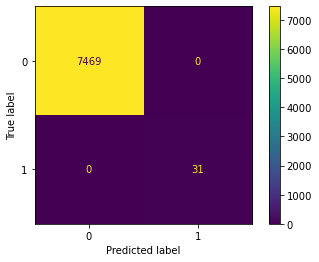

In [96]:
plot_confusion_matrix(cred_model, X_train_sc, y_train);

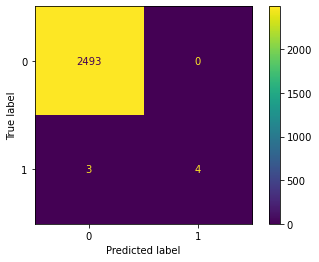

In [97]:
plot_confusion_matrix(cred_model, X_test_sc, y_test);

In [95]:
y_test.value_counts()

0    2493
1       7
Name: Class, dtype: int64

In [98]:
38/len(data)

0.0038

In [101]:
test_preds = cred_model.predict(X_test_sc)
recall_score(y_test, test_preds)

0.5714285714285714

#### Discuss: What do you notice?

- 


## Class Imbalance

In [99]:
# What does a class imbalance look like?
y_train.value_counts()

0    7469
1      31
Name: Class, dtype: int64

### Why do we care?

Think about it - you're asking a computer, which has NO idea what you're talking about or how to identify anything in any way other than how you tell it to identify things, to look at something completely new and categorize it. If you feed it 1000 emails, 950 of which are 'not spam' and 50 of which are 'spam,' and ask it to identify which are 'not spam,' it can just label everything as 'not spam' and be 95% correct! Not bad!

And yet... that doesn't do what you want at all. You want your model to learn the characteristics of 'spam' emails and actually identify the parts of it which are reliable predictors for 'spam' in general, something the computer is increasingly incentivized not to do as the majority in your datasets gets larger compared to the minority. If your target is really imbalanced, your model will have to work increasingly harder in order to do better than the model-less baseline of just predicting the majority class.

## What can we do about it?

### Under-Sampling

Basically, take a sample to reduce the majority class to be the same size as the minority class.

Example:
```
minority = df.loc[df["category"] == "minority"]
majority = df.loc[df["category"] == "majority"].sample(n=len(minority))
```

Problems?

- Losing a lot of observations (in the 50 spam vs 950 not-spam example, we'd lose 900 rows!)


### Over-Sampling

The opposite - keep resampling from our minority class until it's the same size as the majority class.

Example:
```
majority = df.loc[df["category"] == "majority"]
minority = df.loc[df["category"] == "minority"].sample(n=len(majority), replace=True)
```

Problems?

- Will over-fit to the minority class, since it'll see the same minority examples over and over again (in the same 50 spam vs 950 not-spam example, we'd likely repeat each of the rows in the minority class 19 times!)


### Split The Difference

Basically, balance Under and Over sampling so that you do a bit of both - might be better than relying on just one of the above strategies.

### Implementing Over-Sampling

In [102]:
# First, train test split
# We only implement these techniques on training data!
X = data.drop(columns='Class')
y = data['Class']

X_tr_samp, X_te_samp, y_tr_samp, y_te_samp = train_test_split(
    X, y, test_size=.25, random_state=1)

In [103]:
# Need to put our training data back together
train_data = X_tr_samp.copy()
train_data['Class'] = y_tr_samp
train_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
651,492.0,-0.789890,-1.379371,0.171334,-1.636756,-2.807266,0.726236,2.737602,-0.933999,-2.413730,...,-0.256231,0.167077,0.540876,0.067496,0.479636,-0.098230,0.053527,-0.408050,632.40,0
6560,7949.0,-0.944392,1.120606,1.943698,0.438131,0.357940,-0.524502,0.527956,-0.234039,0.785934,...,-0.412873,-0.845279,-0.195698,0.212402,-0.030611,0.138765,-0.189770,-0.062716,3.59,0
8974,12399.0,1.168740,-0.180544,0.741365,0.283013,-0.611288,-0.057707,-0.511689,0.094057,1.881734,...,-0.181691,-0.053286,0.004593,0.247339,0.270206,1.075329,-0.084131,-0.019860,3.30,0
2348,1892.0,-2.183004,-0.401099,0.864277,1.256849,0.797138,-1.377806,0.372290,-0.286859,0.095818,...,-0.098498,0.477961,0.509126,0.388621,-0.052237,-0.316810,-0.024000,0.568065,21.50,0
5670,5930.0,-1.788635,-1.712669,0.986718,-1.975763,2.219729,-1.987765,-0.805166,0.061549,1.989917,...,0.104806,-0.087014,0.216295,-0.540503,-0.149504,-0.229080,0.006315,0.167245,26.64,0


In [106]:
len(train_data)

7500

In [105]:
# Let's try over-sampling our minority class and see how we do
# Copy the provided code above, then adjust to our context
majority = train_data.loc[train_data["Class"] == 0]
minority = train_data.loc[train_data["Class"] == 1].sample(n=len(majority), replace=True)

# Then use pd.concat to combine, resetting the index using .reset_index(drop=True)
oversampled_train = pd.concat([majority, minority]).reset_index(drop=True)
oversampled_train.shape

(14938, 31)

In [107]:
# Split out oversampled_train back out into X and y
X_tr_oversamp = oversampled_train.drop(columns='Class')
y_tr_oversamp = oversampled_train['Class']

In [108]:
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_tr_oversamp)
X_tr_over_sc = scaler.transform(X_tr_oversamp)
X_te_sc = scaler.transform(X_te_samp)

# Train a logistic regresssion model with the train data
over_model = LogisticRegression(random_state=42)
over_model.fit(X_tr_over_sc, y_tr_oversamp)

LogisticRegression(random_state=42)

In [109]:
over_model.score(X_te_sc, y_te_samp)

0.9988

In [114]:
over_model.score(X_tr_over_sc, y_tr_oversamp)

1.0

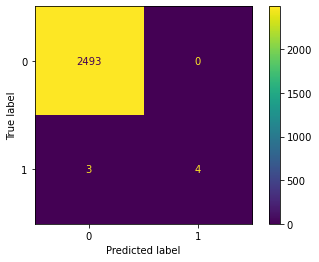

In [110]:
plot_confusion_matrix(over_model, X_te_sc, y_te_samp);

#### Discuss:

- 


### Synthetic Data Creation - ADASYN and SMOTE

The **Synthetic Minority Oversampling Technique (SMOTE)** conducts cluster-based over-sampling. SMOTE works by finding all the instances of the minority category within the observations, drawing lines between those instances, and then creating new observations along those lines.

![SMOTE visualized](images/SMOTE_R_visualisation_3.png)

Image source is a great explainer on SMOTE (but uses R for the examples): https://rikunert.com/SMOTE_explained

This is better than simply using a random over-sample, yet not only are these synthetic samples not real data but also these samples are based on your existing minority. So, those new, synthetic samples can still result in over-fitting, since they're made from our original minority category. An additional pitfall you might run into is if one of your minority category is an outlier - you'll have new data that creates synthetic data based on the line between that outlier and another point in your minority, and maybe that new synthetic data point is also an outlier.

Another way to create synthetic data to over-sample our minority category is the **Adaptive Synthetic approach, ADASYN**. ADASYN works similarly to SMOTE, but it focuses on the points in the minority cluster which are the closest to the majority cluster, aka the ones that are most likely to be confused, and focuses on those. It tries to help out your model by focusing on where it might get confused, where 'spam' and 'not spam' are the closest, and making more data in your 'spam' minority category there.


Check out the library [imblearn](https://imbalanced-learn.org/stable/) for implementation of these!

### Implementing SMOTE:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Reminder: go back to our original train/test split:

```
X_tr_samp, X_te_samp, y_tr_samp, y_te_samp
```

In [115]:
# New import - note, not SKLearn!
from imblearn.over_sampling import SMOTE

In [116]:
# Still need to scale
scaler = StandardScaler()
scaler.fit(X_tr_samp)
X_tr_sc = scaler.transform(X_tr_samp)
X_te_sc = scaler.transform(X_te_samp)

In [117]:
# Instantiate our SMOTE
sm = SMOTE(random_state=42)
# Fit on the training data! X_tr_samp, y_tr_samp
X_tr_smote, y_tr_smote = sm.fit_resample(X_tr_sc, y_tr_samp)

In [118]:
X_tr_smote.shape

(14938, 30)

In [119]:


# Train a logistic regresssion model with the train data
smote_model = LogisticRegression(random_state=42)
smote_model.fit(X_tr_smote, y_tr_smote)

LogisticRegression(random_state=42)

In [120]:
smote_model.score(X_te_sc, y_te_samp)

0.9996

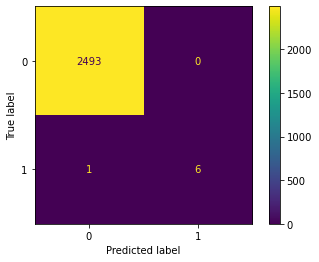

In [121]:
plot_confusion_matrix(smote_model, X_te_sc, y_te_samp);

#### Discuss:

- 


### One More Trick: `class_weight='balanced'`

And then, of course, sklearn has some methods to handle imbalanced datasets built right into some models - including logistic regression!

Check out the documentation to find it: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Reminder: go back to our original train/test split:

```
X_tr_samp, X_te_samp, y_tr_samp, y_te_samp
```

In [122]:
# Let's try a model with an adjusted hyperparameter...
logreg_b = LogisticRegression(class_weight='balanced')

In [123]:
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_tr_samp)
X_tr_sc = scaler.transform(X_tr_samp)
X_te_sc = scaler.transform(X_te_samp)

# Now, fitting our model and grabbing our training and testing predictions
logreg_b.fit(X_tr_sc, y_tr_samp)

train_preds = logreg_b.predict(X_tr_sc)
test_preds = logreg_b.predict(X_te_sc)

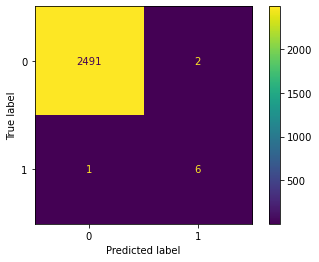

In [124]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(logreg_b, X_te_sc, y_te_samp);

In [125]:
# Printing the metrics nicely
metrics = {"Accuracy": accuracy_score,
           "Recall": recall_score,
           "Precision": precision_score,
           "F1-Score": f1_score}

for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_tr_samp, train_preds):.4f}")
    print(f"TEST: {metric(y_te_samp, test_preds):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 1.0000
TEST: 0.9988
***************
Recall:
TRAIN: 1.0000
TEST: 0.8571
***************
Precision:
TRAIN: 1.0000
TEST: 0.7500
***************
F1-Score:
TRAIN: 1.0000
TEST: 0.8000
***************


## Resources:

- [SMOTE Explained for Noobs](https://rikunert.com/SMOTE_explained) (the R tutorial I linked earlier)
- [Resampling Strategies for Imbalanced Datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
- Machine Learning Mastery: [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Handling Imbalanced Datasets in Deep Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758)